In [234]:
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from datetime import date, timedelta
import time
from google.colab import drive
drive.mount('/content/drive')
!pip install sweetviz
import sweetviz as sv

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [235]:
import seaborn as sns
from matplotlib import pyplot as plt

In [236]:
train_err = pd.read_csv('/content/drive/Shareddrives/dacon/404/train_err2.csv')
train_qui = pd.read_csv('/content/drive/Shareddrives/dacon/404/train_qui2.csv')
train_prob = pd.read_csv('/content/drive/Shareddrives/dacon/404/train_prob2.csv')

test_err = pd.read_csv('/content/drive/Shareddrives/dacon/404/test_err2.csv')
test_qui = pd.read_csv('/content/drive/Shareddrives/dacon/404/test_qui2.csv')

In [237]:
train_qui2 = train_qui.copy()
test_qui2 = test_qui.copy()
train_err2 = train_err.copy()
test_err2 = test_err.copy()

# 퀼리티 3,4는 값이 1밖에 없어서 의미가 없기 때문에 제외
# 펌웨어 버전은 이미 err 자료에 있기 때문에 중복으로 제외
# 퀼리티 0은 EDA 결과 퀼리티 2와 피어슨 상관계수 0.99를 보이기 때문에 0과 2 중에 하나만 골랐음
# 0의 결측치 Nan은 15%고 2의 결측치는 4%기 때문에 결측치가 적은 2를 남기고 0은 drop 시킨다.

## 퀼리티 6과 7도 0.81로 강한 상관관계를 보이고 있는데, 하나를 제외해야 하나 고민이 됨
train_qui2.drop(['fwver','quality_0', 'quality_3', 'quality_4'], axis =1, inplace=True)
test_qui2.drop(['fwver', 'quality_0', 'quality_3', 'quality_4'], axis =1, inplace=True)

test_qui2 = test_qui2.replace(',','', regex=True)
train_qui2 = train_qui2.replace(',','', regex=True)
test_qui2.loc[:,'quality_1':'quality_12'] = test_qui2.loc[:,'quality_1':'quality_12'].astype(float)
train_qui2.loc[:,'quality_1':'quality_12'] = train_qui2.loc[:,'quality_1':'quality_12'].astype(float)

train_qui2['time'] = pd.to_datetime(train_qui['time'], format = '%Y-%m-%d %H:%M:%S')
test_qui2['time'] = pd.to_datetime(test_qui['time'], format = '%Y-%m-%d %H:%M:%S')

train_err2['time'] = pd.to_datetime(train_err2['time'], format = '%Y-%m-%d %H:%M:%S')
test_err2['time'] = pd.to_datetime(test_err2['time'], format = '%Y-%m-%d %H:%M:%S')
train_prob['time'] = pd.to_datetime(train_prob['time'], format = '%Y-%m-%d %H:%M:%S')

In [238]:
# 퀼리티 임계치
# [-1, 0, 1] == -1 카테고리 -1, -1~0 =카테고리 0, 그 이상 = 카테고리 1
qualities = {}

qualities['quality_1'] = [-1,0, 1]
qualities['quality_2'] = [-1,0, 1]
qualities['quality_5'] = [-1,0,1,2,4, 10]
qualities['quality_6'] = [-1,0, 1]
qualities['quality_7'] = [0,1,100, 101]
qualities['quality_8'] = [0,1,2]
qualities['quality_9'] = [0,1,2]
qualities['quality_10'] = [0,1,2,3, 4, 5,7, 10 ,14,15] ##??
qualities['quality_11'] = [-1,0,1]
qualities['quality_12'] = [0,1,2]

## 모델 임계치
## 모델 0,1,2,3,4의 비율을 더하면 99.999% 이므로, 모델 5~8은 other model로 통합하는 것이 바람직 해 보임.

In [239]:
import warnings
warnings.filterwarnings(action='ignore')

In [240]:
def quality_categorize(dataset):
  data = dataset.copy()
  for key in tqdm(qualities):
    intervals = qualities.get(key)
    for i in range(len(intervals)):
      if intervals[i] == intervals[-1]:
        data[key][data[key] >= intervals[i]] =  intervals[i]
      # elif intervals[i+1] - intervals[i] == 1:
      #   continue
      else:
        data[key][(data[key] >= intervals[i]) & (data[key] < intervals[i+1])] = intervals[i]
  return data


In [241]:
train_qui3 = quality_categorize(train_qui2)
test_qui3 = quality_categorize(test_qui2)

In [242]:
train_err2['err'] =  1
train_prob['err'] = 1

In [243]:
import random

User_id = 19556


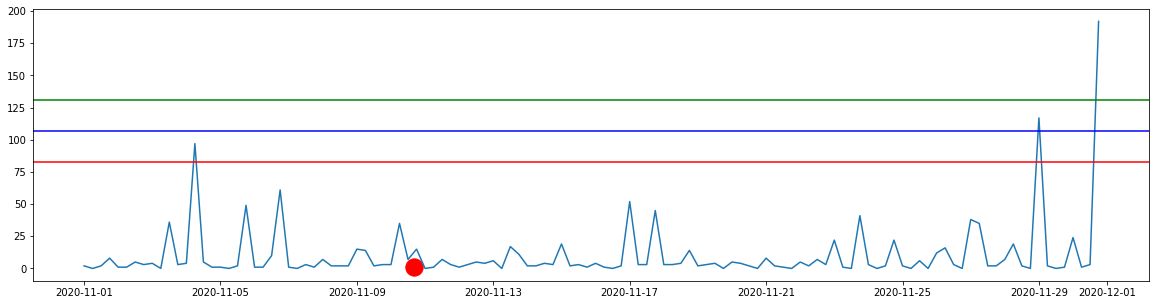

In [244]:
### 랜덤하게 한 명을 뽑아서 간격(interval)당 에러보고 횟수
## 빨간 점은 에러 리포트 시점! 없으면 에러 보고 안한 것

interval = '2h'  # 30분은 '30T', 4시간은 '4h' 등등
id = random.randint(10000,25000)
# err_type = 17
# temp = train_err2[train_err2.errtype == err_type]

temp = train_err2[train_err2['user_id']==id]
prob = train_prob[train_prob.user_id == id]
temp_time = temp.groupby(pd.Grouper(key = 'time', freq = '6h')).sum()
plt.figure(figsize=(20,5))
print('User_id = {}'.format(id))

m =  temp_time['err'].mean()
s = temp_time['err'].std()

UCL = m + 3*s
UCLL = UCL + s
UCLLL = UCL + 2*s

plt.plot(temp_time.index, temp_time.err)
plt.scatter(prob.time, prob.err, c = 'red', s = 300)
plt.axhline(y=UCL, color='r')
plt.axhline(y=UCLL, color='b')
plt.axhline(y=UCLLL, color='g')

# 12808, 12811, 13812
# 12810, 12812

In [245]:
len(temp_time[temp_time['err'] > UCL])

3

User_id = 14319


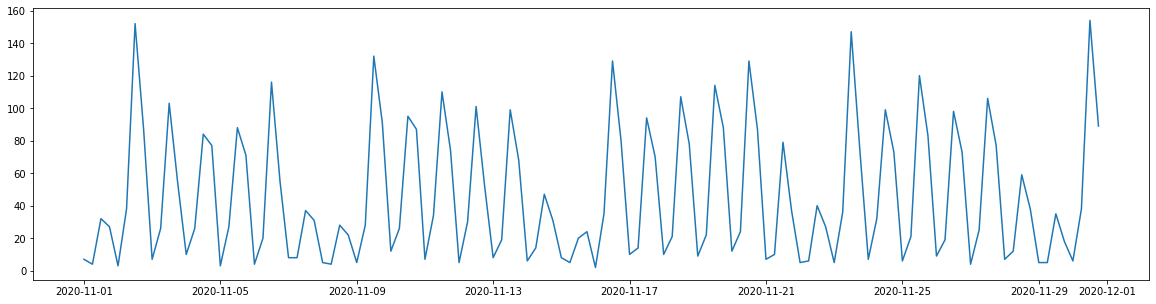

In [246]:
### 랜덤하게 한 명을 뽑아서 간격(interval)당 에러보고 횟수
## 빨간 점은 에러 리포트 시점! 없으면 에러 보고 안한 것

interval = '2h'  # 30분은 '30T', 4시간은 '4h' 등등
id = random.randint(10000,25000)
# err_type = 17
# temp = train_err2[train_err2.errtype == err_type]

temp_time = train_prob.groupby(pd.Grouper(key = 'time', freq = '6h')).sum()
plt.figure(figsize=(20,5))
print('User_id = {}'.format(id))

m =  temp_time['err'].mean()
s = temp_time['err'].std()

UCL = m + 3*s
UCLL = UCL + s
UCLLL = UCL + 2*s

plt.plot(temp_time.index, temp_time.err)

# 12808, 12811, 13812
# 12810, 12812

In [247]:
train_prob

,user_id,time,err
0,19224,2020-11-02 20:00:00,1
1,23664,2020-11-16 14:00:00,1
2,15166,2020-11-14 13:00:00,1
3,12590,2020-11-08 21:00:00,1
4,15932,2020-11-03 21:00:00,1
...,...,...,...
5424,20167,2020-11-25 12:00:00,1
5425,16270,2020-11-10 12:00:00,1
5426,19114,2020-11-06 23:00:00,1
5427,21505,2020-11-04 11:00:00,1


In [248]:
temp_time.head(48)

,user_id,err
time,,
2020-11-01 00:00:00,122453,7
2020-11-01 06:00:00,70496,4
2020-11-01 12:00:00,542849,32
2020-11-01 18:00:00,490562,27
2020-11-02 00:00:00,55617,3
2020-11-02 06:00:00,678273,38
2020-11-02 12:00:00,2784001,152
2020-11-02 18:00:00,1525784,87
2020-11-03 00:00:00,131012,7


In [249]:
train_qui3['err'] = 1

User_id = 19372


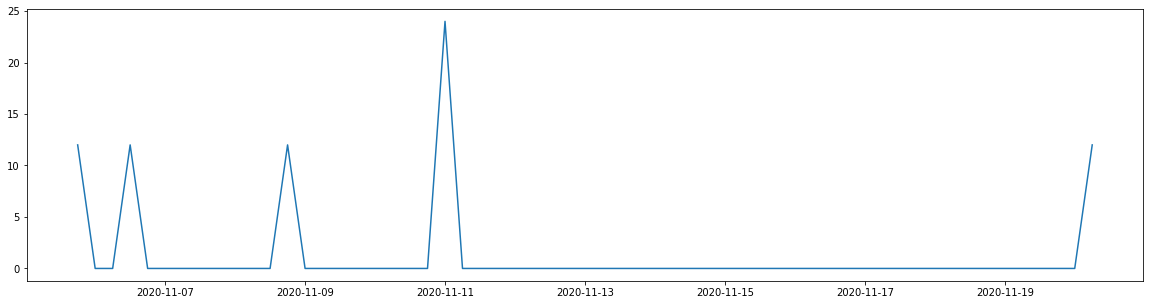

In [250]:
interval = '2h'  # 30분은 '30T', 4시간은 '4h' 등등
id = random.randint(10000,25000)
# err_type = 17
# temp = train_err2[train_err2.errtype == err_type]

temp = train_qui3[train_qui3['user_id']==id]
prob = train_prob[train_prob.user_id == id]
temp_time = temp.groupby(pd.Grouper(key = 'time', freq = '6h')).sum()
plt.figure(figsize=(20,5))
print('User_id = {}'.format(id))
plt.plot(temp_time.index, temp_time.err)
plt.scatter(prob.time, prob.err, c = 'red', s = 300)

# 12808, 12811, 13812
# 12810, 12812

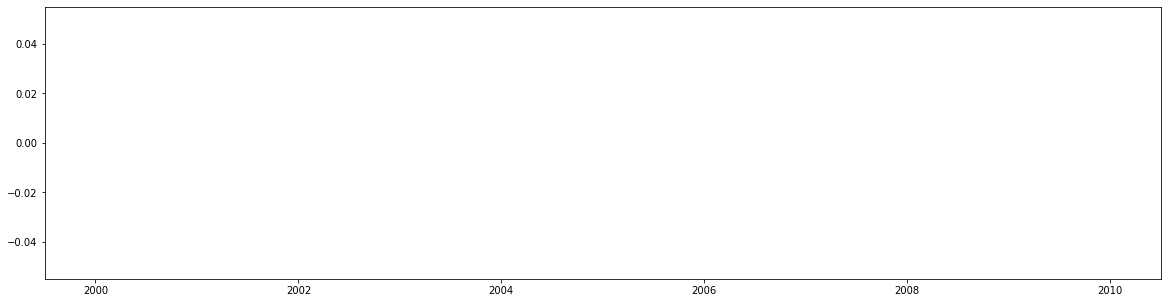

In [251]:
# 위의 버전에서 조금 업데이트
# err_type에 해당하는 에러들만 모아서 시간별 합계를 보여줌.

id = random.randint(10000,25000)
#err_type = [18,19,20,21,25, 34, 35]
err_type = [17]
temp = train_err2[train_err2.errtype.isin(err_type)]

temp = temp[temp['user_id']==id]
prob = train_prob[train_prob.user_id == id]
temp_time = temp.groupby(pd.Grouper(key = 'time', freq = '2h')).sum()
plt.figure(figsize=(20,5))
plt.plot(temp_time.index, temp_time.err)
plt.scatter(prob.time, prob.err, c = 'red', s = 300)

In [253]:
k = train_err2[train_err2.errtype.isin(err_type)]
len(k.user_id.unique())

5747

In [256]:
def err_by_time(dataset, fr = '12h'):
  data = dataset.copy()
  ids = data.user_id.unique()
  ids.sort()
  time_list = []
  data['err'] = 1
  for id in tqdm(ids):
    temp = data[data['user_id']==id]
    temp_time = temp.groupby(pd.Grouper(key = 'time', freq = fr)).sum()
    a = temp_time[['err']].mean().values[0]
    b = temp_time[['err']].std().values[0]

    m =  temp_time['err'].mean()
    s = temp_time['err'].std()

    UCL = m + 3*s
    UCLL = UCL + s
    UCLLL = UCL + 2*s

    c = len(temp_time[temp_time['err'] > UCL])
    d = len(temp_time[temp_time['err'] > UCLL])
    e = len(temp_time[temp_time['err'] > UCLLL])

    time_list.append([a,b,c,d,e])
  df = pd.DataFrame(time_list, index = ids, columns = ['mean', 'std', 'UCL', 'UCLL', 'UCLLL'])
  return df

In [257]:
train_time = err_by_time(train_err2)
test_time = err_by_time(test_err2)
train_time = train_time.fillna(0)
test_time = test_time.fillna(0)

train_time.to_csv("트레인_err_12시간간격.csv")
test_time.to_csv("테스트_err_12시간간격.csv")
!cp 트레인_err_12시간간격.csv "drive/My Drive/"
!cp 테스트_err_12시간간격.csv "drive/My Drive/"

In [262]:
train_err2.errcode

,user_id,model_nm,fwver,errtype,errcode,time,err
0,10000,model_3,05.15.2138,15,1,2020-11-01 02:56:16,1
1,10000,model_3,05.15.2138,12,1,2020-11-01 03:03:09,1
2,10000,model_3,05.15.2138,11,1,2020-11-01 03:03:09,1
3,10000,model_3,05.15.2138,16,1,2020-11-01 05:05:14,1
4,10000,model_3,05.15.2138,4,0,2020-11-01 05:05:15,1
...,...,...,...,...,...,...,...
16554658,24999,model_3,05.15.2138,15,1,2020-11-30 16:30:51,1
16554659,24999,model_3,05.15.2138,16,1,2020-11-30 17:26:25,1
16554660,24999,model_3,05.15.2138,4,0,2020-11-30 17:26:25,1
16554661,24999,model_3,05.15.2138,4,0,2020-11-30 17:26:31,1


In [259]:
train_qui

,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12,time
0,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0,2020-11-29 09:00:00
1,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0,2020-11-29 09:00:00
2,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0,2020-11-29 09:00:00
3,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0,2020-11-29 09:00:00
4,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0,2020-11-29 09:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828619,24997,04.22.1778,0.0,0,0.0,0,0,1,0,0,0,0,17,0,0,2020-11-24 03:30:00
828620,24997,04.22.1778,0.0,0,0.0,0,0,0,0,0,0,0,17,0,0,2020-11-24 03:30:00
828621,24997,04.22.1778,0.0,0,0.0,0,0,3,0,0,0,0,17,0,0,2020-11-24 03:30:00
828622,24997,04.22.1778,0.0,0,0.0,0,0,0,0,0,0,0,17,0,0,2020-11-24 03:30:00


In [260]:
train_prob

,user_id,time,err
0,19224,2020-11-02 20:00:00,1
1,23664,2020-11-16 14:00:00,1
2,15166,2020-11-14 13:00:00,1
3,12590,2020-11-08 21:00:00,1
4,15932,2020-11-03 21:00:00,1
...,...,...,...
5424,20167,2020-11-25 12:00:00,1
5425,16270,2020-11-10 12:00:00,1
5426,19114,2020-11-06 23:00:00,1
5427,21505,2020-11-04 11:00:00,1


In [227]:
train_time.to_csv("트레인_err_2시간간격.csv")
test_time.to_csv("테스트_err_2시간간격.csv")
!cp 트레인_err_2시간간격.csv "drive/My Drive/"
!cp 테스트_err_2시간간격.csv "drive/My Drive/"

In [164]:
temp = temp.fillna(0)
prob_list = train_prob['user_id'].unique()
prob_list.sort()

In [ ]:
temp = temp.reset_index()

In [ ]:
temp['problems'] = temp['index'].isin(prob_list)
temp = temp.set_index('index')

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

temp.iloc[:,:2] = scaler.fit_transform(temp.iloc[:,:2])

In [ ]:
temp_tr = temp[temp['problems']]
temp_fls = temp[temp['problems'] != True]

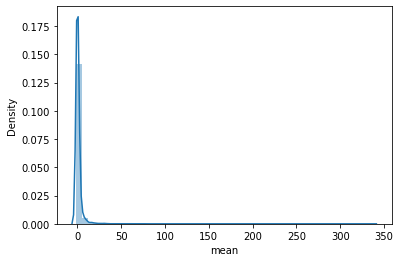

In [ ]:
sns.distplot(temp_tr['mean'])

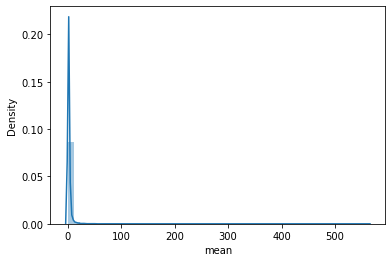

In [ ]:
sns.distplot(temp_fls['mean'])

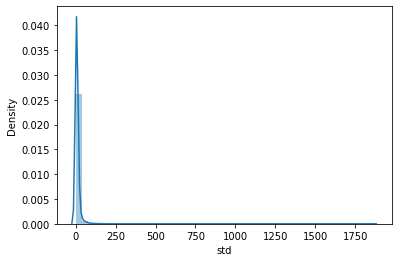

In [ ]:
sns.distplot(temp_tr['std'])

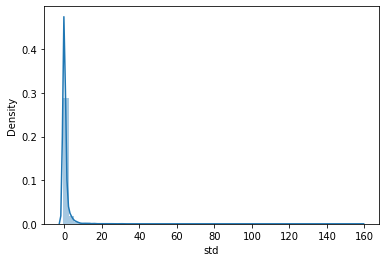

In [ ]:
sns.distplot(temp_fls['std'])

In [ ]:
temp_tr['std'].max()

1858.7845309261313

In [159]:
train_err3 = train_err2[['user_id', 'model_nm', 'errtype', 'errcode', 'time']]
test_err3 = test_err2[['user_id', 'model_nm', 'errtype', 'errcode', 'time']]

In [160]:
# 에러 코드의 분포는 다음과 같다.

print(train_err2.errcode.value_counts())
# 중간에 나오다가 잘리지만.. 전에 발간한 리포트를 보면 상위 15개 에러가 99.9%를 차지하고 있다.
# 따라서 상위 15개는 각각의 카테고리로 주고, 나머지는 16번째 '기타' 카테고리로 묶으면 어떨까 싶습니다.
# 상위 15개 리스트
err_code =['1','0','connection timeout','B-A8002','80','79','14','active','2','84','85','standby','NFANDROID2','connection fail to establish','3']

# 위의 15개에 포함되지 않는 에러코드는 걍 'etc'로 분류
train_err3['errcode'][~train_err3['errcode'].isin(err_code)] = 'ETC'
test_err3['errcode'][~train_err3['errcode'].isin(err_code)] = 'ETC'


## 에러타입은 어차피 41개 뿐이라... 분포도 고른 편 같고... 얌전히 두기로 함.

1                     8906967
0                     2599123
connection timeout    1835600
B-A8002                897863
80                     334018
                       ...   
8019                        1
3755                        1
184780                      1
25957                       1
9181                        1
Name: errcode, Length: 2805, dtype: int64


In [161]:
train_err4 = train_err3.copy()

In [162]:
train_err4['hour'] = train_err4['time'].dt.hour
train_err4['weekday'] = train_err4['time'].dt.weekday

In [165]:
train_err4['problems'] = train_err4.user_id.isin(prob_list)
train_err4_tr = train_err4[train_err4['problems']]
train_err4_fls = train_err4[train_err4['problems'] != True]

In [166]:
train_err4_tr

,user_id,model_nm,errtype,errcode,time,hour,weekday,problems
317,10001,model_2,15,1,2020-11-01 02:04:15,2,6,True
318,10001,model_2,15,1,2020-11-01 02:04:15,2,6,True
319,10001,model_2,31,1,2020-11-01 02:04:15,2,6,True
320,10001,model_2,33,2,2020-11-01 02:04:15,2,6,True
321,10001,model_2,12,1,2020-11-01 02:04:21,2,6,True
...,...,...,...,...,...,...,...,...
16554088,24998,model_0,15,1,2020-11-29 05:08:46,5,6,True
16554089,24998,model_0,16,1,2020-11-30 13:26:04,13,0,True
16554090,24998,model_0,31,0,2020-11-30 13:26:24,13,0,True
16554091,24998,model_0,40,1,2020-11-30 21:03:51,21,0,True


In [ ]:
tr = pd.DataFrame(train_err4_tr['errtype'].value_counts().sort_index())
all = pd.DataFrame(train_err4['errtype'].value_counts().sort_index())

In [ ]:
tr.transpose()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,41,42
errtype,4016,9310,13940,363153,423956,28187,30025,28,54,96989,126391,132926,16363,125541,640140,513531,21257,2339,554,1809,506,964736,1250243,17646,1060,202030,294144,294513,281,868235,538238,69366,122748,7406,3860,3874,2349,8819,327526,48787,11905


In [ ]:
k = tr/all
k.transpose()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,41,42
errtype,0.186401,0.356623,0.453215,0.280049,0.444902,0.558357,0.577482,0.168675,0.495413,0.727038,0.411657,0.415159,0.716324,0.498149,0.398853,0.41103,0.462018,0.875702,0.834337,0.869712,0.833608,0.517185,0.549192,0.451639,0.89527,0.37664,0.543901,0.54108,0.699005,0.437333,0.476079,0.388655,0.741518,0.727005,0.414296,0.414953,0.517515,0.557459,0.448434,0.468484,0.346337


In [270]:
train_err3

,user_id,model_nm,errtype,errcode,time
0,10000,model_3,15,1,2020-11-01 02:56:16
1,10000,model_3,12,1,2020-11-01 03:03:09
2,10000,model_3,11,1,2020-11-01 03:03:09
3,10000,model_3,16,1,2020-11-01 05:05:14
4,10000,model_3,4,0,2020-11-01 05:05:15
...,...,...,...,...,...
16554658,24999,model_3,15,1,2020-11-30 16:30:51
16554659,24999,model_3,16,1,2020-11-30 17:26:25
16554660,24999,model_3,4,0,2020-11-30 17:26:25
16554661,24999,model_3,4,0,2020-11-30 17:26:31


In [269]:
pd.get_dummies(train_err3['errcode'])

,0,1,14,2,3,79,80,84,85,B-A8002,ETC,NFANDROID2,active,connection fail to establish,connection timeout,standby
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16554658,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16554659,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16554660,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16554661,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
